# Discover the data

In [293]:
import nltk
import re
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from elasticsearch import Elasticsearch
from faker import Faker
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [251]:
df = pd.read_csv("../src/emotions.csv")

In [252]:
df.sample(5)

Text  Emotion
19844  ill admit there is definitely some sort of tes...    anger
16127  i am going to have to check on in just a few m...     fear
8458   i looked down at my sweet boy hudson i knew th...  sadness
18003                  i am just feeling cranky and blue    anger
19081       i am beginning to feel like a fabulous adult    happy

In [253]:
df.head(5)

Text  Emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

In [254]:
df["Emotion"].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [255]:
# check the 5 most common words in the Text column
df["Text"].apply(lambda x: len(x.split())).sort_values(ascending=False).head(5)

6322    66
7222    64
9618    64
9626    64
46      64
Name: Text, dtype: int64

In [256]:
# rename columns
df.rename(columns={"Text": "text", "Emotion": "emotion"}, inplace=True)

In [257]:
df.head()

text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

# NLTK

In [258]:
nltk.download("stopwords") # for stopwords
nltk.download("wordnet") # for lemmatization
nltk.download("punkt") # for tokenization

[nltk_data] Downloading package stopwords to /Users/ant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ant/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [259]:
stopwords_eng = set(stopwords.words("english"))

In [260]:
stopwords_eng

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

## Lemmatizer

In [261]:
lemmatizer = WordNetLemmatizer()

In [262]:

def clean_text(text):
    """
    args: text - string
    returns: cleaned text
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_eng]
    return words

In [263]:
df['text_clean'] = df['text'].apply(clean_text)

In [264]:
df.head(5)

text  emotion  \
0                            i didnt feel humiliated  sadness   
1  i can go from feeling so hopeless to so damned...  sadness   
2   im grabbing a minute to post i feel greedy wrong    anger   
3  i am ever feeling nostalgic about the fireplac...     love   
4                               i am feeling grouchy    anger   

                                          text_clean  
0                          [didnt, feel, humiliated]  
1  [go, feeling, hopeless, damned, hopeful, aroun...  
2  [im, grabbing, minute, post, feel, greedy, wrong]  
3  [ever, feeling, nostalgic, fireplace, know, st...  
4                                 [feeling, grouchy]

In [265]:
emotions_distribution = df['emotion'].value_counts()

In [266]:
emotion_words = {}
for emotion in df['emotion'].unique():
    words = []
    for text in df[df['emotion'] == emotion]['text_clean']:
        words.extend(text)
    emotion_words[emotion] = Counter(words).most_common(30)

In [267]:
emotion_words

{'sadness': [('feel', 4194),
  ('feeling', 2053),
  ('like', 1082),
  ('im', 875),
  ('really', 352),
  ('time', 351),
  ('know', 350),
  ('get', 299),
  ('day', 287),
  ('would', 273),
  ('thing', 268),
  ('little', 267),
  ('ive', 266),
  ('make', 266),
  ('want', 249),
  ('life', 244),
  ('one', 244),
  ('still', 243),
  ('even', 239),
  ('people', 231),
  ('think', 225),
  ('bit', 221),
  ('much', 191),
  ('dont', 190),
  ('way', 175),
  ('something', 170),
  ('back', 169),
  ('going', 164),
  ('could', 159),
  ('go', 150)],
 'anger': [('feel', 1856),
  ('feeling', 978),
  ('like', 480),
  ('im', 426),
  ('time', 175),
  ('really', 171),
  ('get', 167),
  ('know', 151),
  ('people', 150),
  ('want', 137),
  ('little', 136),
  ('thing', 136),
  ('even', 125),
  ('would', 118),
  ('angry', 116),
  ('one', 115),
  ('think', 113),
  ('way', 111),
  ('could', 108),
  ('make', 107),
  ('bit', 103),
  ('day', 97),
  ('offended', 92),
  ('dont', 91),
  ('resentful', 87),
  ('cold', 86),
  

In [268]:
vectorizer_tfidf = TfidfVectorizer()
data_tfidf = vectorizer_tfidf.fit_transform(df['text_clean'].apply(lambda x: ' '.join(x)))

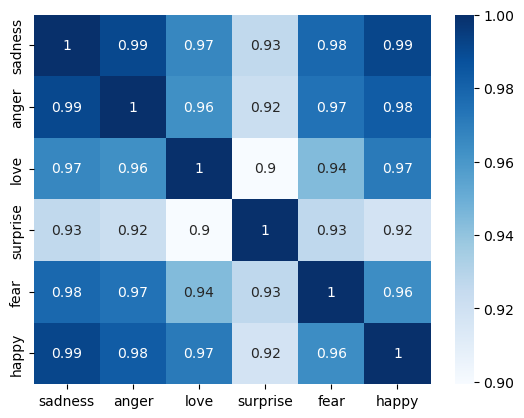

In [269]:
emotion_vectors = {}
for emotion, words in emotion_words.items():
    emotion_vectors[emotion] = np.zeros(len(vectorizer_tfidf.get_feature_names_out()))
    for word, count in words:
        if word in vectorizer_tfidf.vocabulary_:
            index = vectorizer_tfidf.vocabulary_[word]
            emotion_vectors[emotion][index] = count

emotion_similarity = cosine_similarity(list(emotion_vectors.values()))

sns.heatmap(emotion_similarity, xticklabels=emotion_vectors.keys(), yticklabels=emotion_vectors.keys(), annot=True, cmap='Blues')
plt.show()

# Create model - Logistic regressor

In [270]:
le = LabelEncoder()

In [271]:
df['emotion_encoded'] = le.fit_transform(df['emotion'])

In [272]:
df

text  emotion  \
0                                i didnt feel humiliated  sadness   
1      i can go from feeling so hopeless to so damned...  sadness   
2       im grabbing a minute to post i feel greedy wrong    anger   
3      i am ever feeling nostalgic about the fireplac...     love   
4                                   i am feeling grouchy    anger   
...                                                  ...      ...   
21454               Melissa stared at her friend in dism     fear   
21455  Successive state elections have seen the gover...     fear   
21456               Vincent was irritated but not dismay     fear   
21457  Kendall-Hume turned back to face the dismayed ...     fear   
21458                    I am dismayed , but not surpris     fear   

                                              text_clean  emotion_encoded  
0                              [didnt, feel, humiliated]                4  
1      [go, feeling, hopeless, damned, hopeful, aroun...                4  
2      [im, grabbing, minute, post, feel, greedy, wrong]                0  
3      [ever, feeling, nostalgic, fireplace, know, st...                3  
4                                     [feeling, grouchy]                0  
...                                                  ...              ...  
21454                    [melissa, stared, friend, dism]                1  
21455  [successive, state, election, seen, governing,...                1  
21456                       [vincent, irritated, dismay]                1  
21457  [kendallhume, turned, back, face, dismayed, coup]                1  
21458                                [dismayed, surpris]                1  

[21459 rows x 4 columns]

In [273]:
# # TF-IDF
# X_train, X_test, y_train, y_test = train_test_split(data_tfidf, df['emotion'], test_size=0.2, random_state=42)
# model_tfidf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
# model_tfidf_rf.fit(X_train, y_train)
# predictions_tfidf = model_tfidf_rf.predict(X_test)
# print("TF-IDF Model Performance with Random Forest:")
# print(classification_report(y_test, predictions_tfidf))

In [274]:
from sklearn.linear_model import LogisticRegression

# Create model - Logistic Regression
le = LabelEncoder()
df['emotion_encoded'] = le.fit_transform(df['emotion'])

# TF-IDF
X_train, X_test, y_train, y_test = train_test_split(data_tfidf, df['emotion_encoded'], test_size=0.2, random_state=42)

# Create and fit the model
model_tfidf_lr = LogisticRegression(max_iter=500, random_state=42)
model_tfidf_lr.fit(X_train, y_train)

# Make predictions on the test data
predictions_tfidf = model_tfidf_lr.predict(X_test)

print("TF-IDF Model Performance with Logistic Regression:")
print(classification_report(y_test, predictions_tfidf))

# Your new text
new_text = "I am over the moon! Everything is going perfectly today!"

# Preprocess the text
new_text_clean = clean_text(new_text)

# Transform the text into numeric vectors
new_text_vectorized = vectorizer_tfidf.transform([' '.join(new_text_clean)])

# Make a prediction
prediction = model_tfidf_lr.predict(new_text_vectorized)

# If your labels have been encoded, you can decode them to get the original label
prediction_label = le.inverse_transform(prediction)

# Mesure de confiance
confidence = np.max(model_tfidf_lr.predict_proba(new_text_vectorized))

print("Prediction:", prediction_label)
print("Confidence:", confidence)

TF-IDF Model Performance with Logistic Regression:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       617
           1       0.87      0.78      0.83       531
           2       0.84      0.97      0.90      1381
           3       0.91      0.64      0.76       318
           4       0.89      0.95      0.92      1277
           5       0.86      0.53      0.65       168

    accuracy                           0.87      4292
   macro avg       0.88      0.78      0.82      4292
weighted avg       0.88      0.87      0.87      4292

Prediction: ['happy']
Confidence: 0.5105473511167136


In [275]:
# prediction_label = le.inverse_transform(prediction)
# print("Prediction:", prediction_label)
# print("Confidence:", confidence)

In [276]:
with open('../src/logistic_regressor_model.pkl', 'wb') as file:
    pickle.dump(model_tfidf_lr, file)

In [277]:
df.to_csv('../src/emotion_final.csv', index=False)

# Elastic Search

In [278]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200,'scheme': 'http'}])# connect to Elasticsearch
fake_generator = Faker() # create a Faker object

In [279]:
path = "../src/logistic_regressor_model.pkl"

with open(path, 'rb') as file:
    model = pickle.load(file)

In [280]:
notes = "notes"

# Create a mapping
mapping = {
    "mappings": {
        "properties": {
            "patient_lastname": {"type": "keyword"},
            "patient_firstname": {"type": "keyword"},
            "text": {"type": "text"},
            "date": {"type": "date"},
            "patient_left": {"type": "boolean"},
            "emotion": {"type": "keyword"},
            "confidence": {"type": "float"},
        }
    }
}

# Check if the index exists and delete it if it does
if es.indices.exists(notes):
    es.indices.delete(index=notes)

es.indices.create(index=notes, body=mapping)

/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


{'acknowledged': True, 'shards_acknowledged': True, 'index': 'notes'}

In [281]:
def preprocess_text(text):
    """
    args: text - string
    returns: cleaned text
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    words = nltk.word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stopwords_eng]
    return ' '.join(words)

In [289]:
csv_file_path = "../src/emotion_final.csv"  # Remplacez par le chemin vers votre fichier CSV
df = pd.read_csv(csv_file_path)

# Generate a list of patients
patient_names = []
print("/!\ Patient generation...")
for _ in range(200):
    patient_names.append((fake_generator.last_name(), fake_generator.first_name()))
    
print("/!\ Patient generated")
print("--------------------------------")
print("/!\ Start indexing...")
for i in range(df.shape[0]):
    patient_lastname, patient_firstname = patient_names[i % 200]
    text = df['text'].iloc[i]
    date = fake_generator.date_between(start_date='-1y', end_date='today')
    patient_left = fake_generator.boolean()

    processed_text = preprocess_text(text)
    text_vector = vectorizer_tfidf.transform([processed_text])

    emotion = model.predict(text_vector)[0]
    confidence = model.predict_proba(text_vector)[0].max()
    
    prediction_emotion = le.inverse_transform([emotion])

    document = {
        "patient_lastname": patient_lastname,
        "patient_firstname": patient_firstname,
        "text": text,
        "date": date,
        "patient_left": patient_left,
        "emotion": prediction_emotion,
        "confidence": confidence
    }
 
    es.index(index="notes", body=document)
print("/!\ Indexing done") 

/!\ Patient generation...
/!\ Patient generated
--------------------------------
/!\ Start indexing...


/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not e

/!\ Indexing done


/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)
/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not e

In [291]:
# res = es.search(index="notes", body={"query": {"match_all": {}}}, size=10)
res = es.search(index="notes", body={"query": {"bool": {"must" :[{"match": {"emotion":"happy"}}]}}}, size=10)


for hit in res['hits']['hits']:
    print("Document ID: %3r  Match score: %5.2f" % (hit['_id'], hit['_score']))
    print(hit['_source'], "\n")

Document ID: 'Pu-vMIkB3zbH_eK8OBBV'  Match score:  1.04
{'patient_lastname': 'Campbell', 'patient_firstname': 'Jamie', 'text': 'i have been with petronas for years i feel that petronas has performed well and made a huge profit', 'date': '2023-05-02', 'patient_left': False, 'emotion': 'happy', 'confidence': 0.5900538950658026} 

Document ID: 'Qe-vMIkB3zbH_eK8OBBg'  Match score:  1.04
{'patient_lastname': 'Juarez', 'patient_firstname': 'Tammie', 'text': 'i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter', 'date': '2022-10-14', 'patient_left': True, 'emotion': 'happy', 'confidence': 0.8271771849034735} 

Document ID: 'RO-vMIkB3zbH_eK8OBBr'  Match score:  1.04
{'patient_lastname': 'Ferguson', 'patient_firstname': 'Karla', 'text': 'i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a 

/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


# Request

### **Question 1** : By searching the elastic search database, you will end up with a data frame displaying the distribution of text sentiments for a patient (surname/first name)

In [296]:
search_query = es.search(
    index="notes",
    body={
        "query": {
            "bool": {
                "must": [
                    {"term": {"patient_lastname": "Davis"}},
                    {"term": {"patient_firstname": "Scott"}},
                ]
            }
        },
        "_source": ["emotion", "text"]
    }
) 
sentiments = [doc["_source"]["emotion"] for doc in search_query['hits']['hits']]
texts = [doc["_source"]["text"] for doc in search_query['hits']['hits']]


df_davis_scott = pd.DataFrame({"Sentiment": sentiments, "Text": texts})

/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


In [297]:
df_davis_scott

Sentiment                                               Text
0     happy  i am not sure what would make me feel content ...
1      fear  i feel like that s so weird that i had cancer ...
2   sadness  i dont know where i want to work because there...
3     happy  im feeling rather pleased with myself tonight ...
4   sadness  i missed about a month combined of classes and...
5      fear                                i feel confused too
6   sadness                         i stay up and feel foolish
7   sadness              im feeling a little stressed about it
8      fear  i chose to share that little personal snippet ...
9     anger  i feel really wronged in fact what hu jia did ...

### **Question 2** :Draw up a matrix of contradictory feelings (still using the elastic search database).
We want to know what percentage of documents classified as happy contain the word "sadness". Then what percentage contains "fear" ...
And this for all the sentiments.
The results are represented in a HeatMap.

In [298]:
def emotion_count(es,emotion):
    query = {
        "size": 0,
        "query": {
            "terms": {
                "emotion": [emotion]
            }
        }
    }
   
    response = es.search(index="notes", body=query)

    return response["hits"]["total"]["value"]


def get_happy_percentage(es,emotion,emotion_word):
    query = {
        "size": 0,
        "query": {
            "terms": {
                "emotion": [emotion]
            }
        },
        "post_filter": {
            "match": {
                "text": emotion_word
            }
        }
    }

    
    response = es.search(index="notes", body=query)

    return response["hits"]["total"]["value"]



get_happy_percentage(es,'happy','fear')
emotion_count(es,'happy')

/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


10000

/Users/ant/miniconda3/envs/nlp/lib/python3.11/site-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.17/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


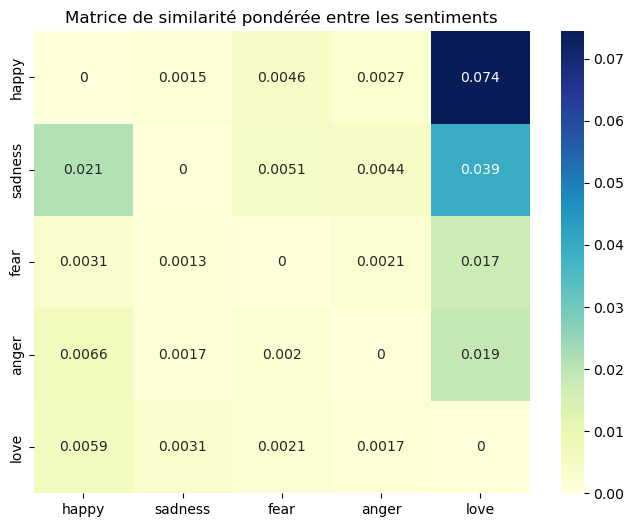

In [300]:
weighted_similarity_matrix = pd.DataFrame(0, index=['happy','sadness','fear','anger','love'], columns=['happy','sadness','fear','anger','love'])

for emotion1 in ['happy','sadness','fear','anger','love']:
    count_emotion1 = emotion_count(es,emotion1)
    for emotion2 in ['happy','sadness','fear','anger','love']:
        if emotion1!= emotion2:
            similarity = get_happy_percentage(es,emotion1,emotion2)/count_emotion1
            weighted_similarity_matrix.loc[emotion1, emotion2] = similarity

# Afficher la matrice de similarité pondérée sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(weighted_similarity_matrix, annot=True, cmap="YlGnBu")
plt.title("Matrice de similarité pondérée entre les sentiments")
plt.show()

### **Question 3** :For each of the stages of grief (denial, anger, bargaining, depression, and acceptance) find the number of texts corresponding to the help:
a full search
a fuzzy search.


In [301]:
def search_text_by_depression_stage(es,stage):
    query = {
        "size": 0,
        "query": {
            "match": {
                "text": stage
            }
        }
    }

    response = es.search(index="notes", body=query)
    total_docs = response["hits"]["total"]["value"]
    
    return total_docs


def fuzzy_search_text_by_depression_stage(es,stage):
    query = {
        "size": 0,
        "query": {
            "fuzzy": {
                "text": {
                    "value": stage,
                    "fuzziness": "AUTO"
                }
            }
        }
    }

    response = es.search(index="notes", body=query)
    total_docs = response["hits"]["total"]["value"]
    
    return total_docs

In [302]:
search_text_by_depression_stage(es,'denial')

6

In [303]:
fuzzy_search_text_by_depression_stage(es,'denial')

375

### **Question 4** :Look for texts :
- which must match the expression "good day" (must) in patients still in consultation (filter)
- which contain "to rest" (should) if possible
- which must not have a confidence threshold of less than 0.5, if this exists. 
- Observe the distribution of these results by sentiment



In [306]:
def search_matching_texts(es):
    query = {
        "query": {
            "bool": {
                "must": [
                    {"match": {"text": "good day"}},
                    {"term": {"patient_left": False}}
                ],
                "should": [
                    {"match": {"text": "to rest"}}
                ],
                "filter": [
                    {"range": {"confidence": {"gte": 0.5}}}
                ]
            }
        }
    }

    response = es.search(index="notes", body=query)
    hits = response["hits"]["hits"]
    matching_texts = [hit["_source"]["text"] for hit in hits]
    
    return matching_texts

In [307]:
search_matching_texts(es)

['i end up feeling exhausted for all the rest of the day',
 'i end up feeling exhausted for all the rest of the day',
 'i either feel like crap about myself all day and try to make up for it the rest of the day and am exhausted',
 'i either feel like crap about myself all day and try to make up for it the rest of the day and am exhausted',
 'im trying to give it my good old space feeling but rest assured that will change at some point',
 'i end up feeling groggy the rest of the day amp guilty that i didnt get anything done',
 'i end up feeling groggy the rest of the day amp guilty that i didnt get anything done',
 'i am off on wednesday to a postgraduate open day but there will be plenty to write about the rest of the week i feel sure',
 'i was feeling pretty anxious all day but my first day at work was a very good day and that helped a lot',
 'i was feeling pretty anxious all day but my first day at work was a very good day and that helped a lot']

### **Question 5**:What is sharding, and how could we imagine sharding on this index?

Sharding is a method of distributing data across multiple machines. A single Elasticsearch index can be divided into multiple "shards", each of which is an autonomous index holding a portion of the data. Each shard is itself a fully functional instance of Lucene, and is therefore an autonomous unit of indexing and searching.

For this index, sharding could be performed according to different criteria depending on the needs of the application. For example, if the distribution of feelings is fairly uniform, we could consider sharding the index according to emotion to distribute the data fairly. Another possibility would be to shard by date, for example by creating a shard by year or month.

### **Question 6**:Which ingestion pipelines would be relevant to our topic?

An ingestion pipeline is a series of processors that perform transformations on data when it is ingested into Elasticsearch. The processors are executed in order, and the result of each processor is passed on to the next in the chain.

For our topic, several ingestion pipelines might be useful:

A pipeline for text preparation: this pipeline could perform tasks such as stopword removal, lemmatisation, conversion to lower case, etc.
A pipeline for entity extraction: this pipeline could identify names, places and other entities in the text.
A pipeline for sentiment analysis: this pipeline could use a pre-trained model to assign a sentiment score to each document.